# ML Course 2023 |  Sentiment Analysis in Twitter Challenge
You can check the updated leaderboard in this [link](https://nimble-hellebore-184.notion.site/ML-Course-2023-Sentiment-Analysis-in-Twitter-Challenge-966b041e7aec4f2eabbc8dc33d64b871).

In [84]:
!pip3 install tueplots==0.0.5
!pip3 install sentence-transformers==2.2.2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Load Tweets

The dataframe of tweets contain the following columns:

- `id`: The unique identifier of the tweet
- `text`: The content of the tweet
- `type`: The type of tweet, which can be 'tweet', 'quoted', 'retweeted' or 'quoted__replied_to'
- `author_id`: The unique identifier of the author of the tweet
- `possibly_sensitive`: A boolean value indicating whether the tweet contains sensitive content
- `retweet_count`: The number of times the tweet has been retweeted
- `quote_count`: The number of times the tweet has been quoted
- `reply_count`: The number of times the tweet has been replied to
- `like_count`: The number of times the tweet has been liked
- `followers_count`: The number of followers of the author of the tweet
- `following_count`: The number of accounts the author of the tweet is following
- `tweet_count`: The total number of tweets made by the author of the tweet
- `listed_count`: The number of lists the author of the tweet is a member of
- `score_compound`:  A numerical value ranging from -1 to 1 indicating the overall sentiment of the tweet, where -1 represents  negative sentiment and 1 represents positive sentiment. **This is the target variable for the regression task.**
- `sentiment`: A categorical variable indicating the sentiment of the tweet, which can be 'negative', 'neutral' or 'positive'. **This is the target variable for the classification task.**




In [85]:
import os
import pandas as pd
pd.set_option('display.max_rows', 100)

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
from tueplots import bundles

plt.rcParams.update(bundles.icml2022())
import tueplots.constants.color.palettes as tue_palettes

from sentence_transformers import SentenceTransformer, models

import matplotlib as mpl
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)

import numpy as np

from sklearn.model_selection import train_test_split
from torch import nn


In [86]:
test_data_path = "https://raw.githubusercontent.com/sevaraakhbaeva/twitter-sentiment-analysis-ML23/main/data/tweets_test_1.csv"
train_data_path = "https://raw.githubusercontent.com/sevaraakhbaeva/twitter-sentiment-analysis-ML23/main/data/tweets_train.csv"

In [87]:
team_id = '1' #put your team id here
split = 'test_1' # replace by 'test_2' for FINAL submission

df = pd.read_csv(train_data_path)
df_test = pd.read_csv(train_data_path)

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'raw.githubusercontent.com'. (_ssl.c:1131)>

In [ ]:
df[df.type == 'tweet'].head()

In [ ]:
df_test.head()

# Pre-process tweets

The following are the preprocessing steps we followed to get the `words` column from the original tweet, which corresponds to the `text` column of the dataframe.

- Remove punctuations, special characters, mentions, links, and numbers from the tweets.
- Convert all the tweets to lowercase.
- Tokenize the tweets into individual words.
- Remove stop words, such as "and", "the", "a", etc.
- Perform stemming or lemmatization on the remaining words to convert them to their base form.
- Filter out any words that occur infrequently in the corpus to reduce the dimensionality of the data.
- Create a bag of words representation of the tweets, where each tweet is represented as a vector of word frequencies.


**Note:** Lemmatization is a process in natural language processing where words are reduced to their base form, or lemma. This is done by removing inflections, such as pluralization or verb conjugation, and converting the word to its dictionary form. The result of this process is a word that is more easily recognizable, and can be used to improve the accuracy of NLP models, such as the LDA model. By lemmatizing the words in a corpus of text, the dimensionality of the data is reduced, and the relationships between words become clearer, making it easier to identify patterns and themes within the text.


# Make training&model selection and test split of tweets_train.csv

In [98]:
df, df_inner_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df["sentiment"])

In [99]:
df['words_str'] = df['words'].apply(lambda words: ' '.join(eval(words)))
df_inner_test['words_str'] = df['words'].apply(lambda words: ' '.join(eval(words)))
df_test['words_str'] = df_test['words'].apply(lambda words: ' '.join(eval(words)))

In [100]:
df.head()

,id,text,type,author_id,possibly_sensitive,retweet_count,quote_count,reply_count,like_count,followers_count,following_count,tweet_count,listed_count,words,score_compound,sentiment,words_str
4891,1535919096218300416,May his prediction match his knowledge of hist...,quoted,3363584909,False,0,1,2,14,65506,113,15406,856,"['may', 'prediction', 'match', 'knowledge', 'h...",0.7184,neutral,may prediction match knowledge history make be...
1509,1375539628267175937,Can modern GPUs avoid partially-filled pixel q...,tweet,175624200,False,17,8,32,220,1031629,225,16316,6967,"['modern', 'gpus', 'avoid', 'partially', 'fill...",-0.2960,neutral,modern gpus avoid partially filled pixel quads...
4808,1597730724823838720,But here is a funny fact: given an NxN symmetr...,replied_to,48008938,False,5,0,8,59,427851,582,12949,6488,"['funny', 'fact', 'given', 'nxn', 'symmetric',...",0.8885,positive,funny fact given nxn symmetric matrix dissimil...
4266,1583249238737444866,@MelMitchell1 @mpshanahan @LucyCheke also this...,replied_to,232294292,False,0,0,4,7,86646,5312,26291,2422,['also'],0.0000,neutral,also
5258,1615447036689788928,RT @GaryMarcus: @flabaster @Grady_Booch Most p...,retweeted,232294292,False,5,0,0,0,86646,5312,26291,2422,"['people', 'underestimate', 'think', 'replaced...",-0.3566,neutral,people underestimate think replaced large lang...


# Sentiment Analysis

**In this part, we will visualize the distribution of these possible sentiments in our dataset.**

Each tweet in our dataset have one of three sentiments (`sentiment`):

*   Positive
*   Neutral
*   Negative

Also, each tweet has a continous score (`score_compound`) between [-1,1] where -1 corresponds to negative and 1 corresponds to a positive sentinement.

In [101]:
df_pos = df[df.sentiment == 'positive']
df_neu = df[df.sentiment == 'neutral']
df_neg = df[df.sentiment == 'negative']


num_total = len(df)
num_pos = len(df_pos)
num_neu = len(df_neu)
num_neg = len(df_neg)

print(f"Num. positive tweets: {num_pos} ({num_pos/num_total*100:.2f}%)")
print(f"Num. negative tweets: {num_neg} ({num_neg/num_total*100:.2f}%)")
print(f"Num. neutral tweets: {num_neu} ({num_neu/num_total*100:.2f}%)")


Num. positive tweets: 1141 (27.86%)
Num. negative tweets: 247 (6.03%)
Num. neutral tweets: 2708 (66.11%)


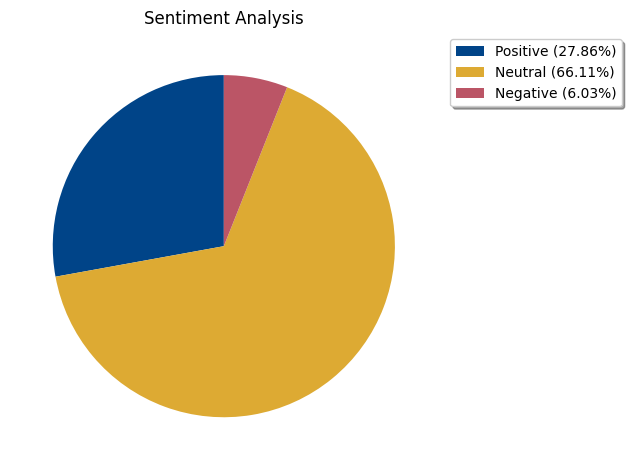

In [102]:
plt.close('all')

fig, ax = plt.subplots(1, 1)

labels = []
labels.append(f"Positive ({num_pos/num_total*100:.2f}%)")
labels.append(f"Neutral ({num_neu/num_total*100:.2f}%)")
labels.append(f"Negative ({num_neg/num_total*100:.2f}%)")

sizes = [num_pos, num_neu, num_neg]

colors = [f"#{i}" for i in tue_palettes.high_contrast[:3]]

_ = ax.pie(sizes,colors=colors, startangle=90)
# plt.style.use(default’)
ax.legend(labels,
          loc='upper center', 
          bbox_to_anchor=(1.23, 1.0), 
          fancybox=True, 
          shadow=True)

ax.set_title("Sentiment Analysis")
plt.tight_layout()
plt.show()

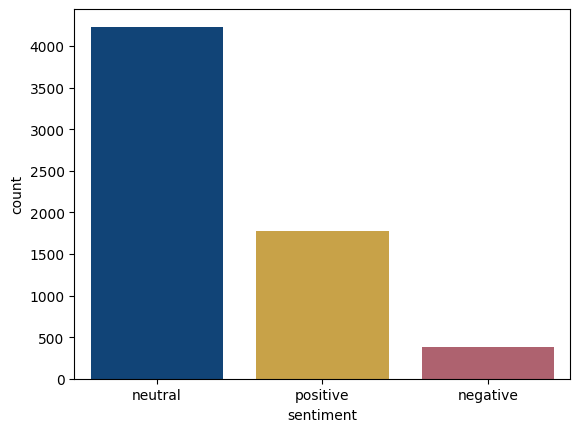

In [12]:
plt.close('all')

sns.countplot(x=df.sentiment, palette=colors)
plt.show()

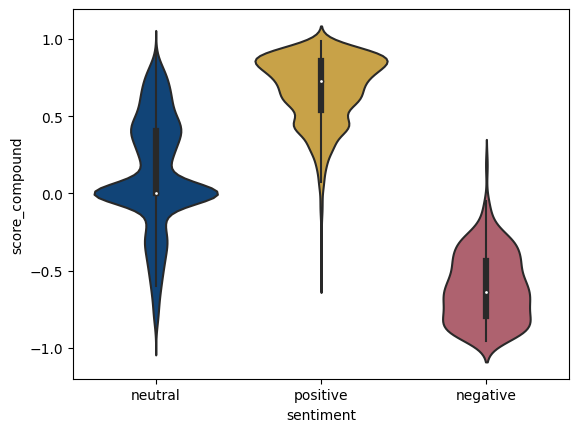

In [13]:
plt.close('all')

sns.violinplot(data=df, x='sentiment', y='score_compound', palette=colors)
plt.show()

# Obtain the text embeddings

When working with natural language processing tasks, such as text classification, it is common to use word embeddings to represent the meaning of words and sentences. Word embeddings are dense vectors that capture the semantic relationships between words in a way that allows for easier processing by machine learning algorithms.

The process of creating word embeddings involves training a neural network on a large corpus of text data. However, pre-trained word embeddings are readily available online and can be downloaded and used in your projects. See a complete list of pre-trained models [here](https://github.com/UKPLab/sentence-transformers/blob/master/docs/pretrained-models/sts-models.md). 


**Note:** When working with pre-trained models, it is important to keep in mind the computational resources required to generate the embeddings. Depending on the size of the model and the amount of text data being processed, generating embeddings may take a significant amount of time. Therefore, it is advisable to save the embeddings locally once they have been generated, to avoid the need to re-generate everytime you may want to make changes in the model (but not in the embedding).



In [105]:
# getting text-embeddings
name = "paraphrase-xlm-r-multilingual-v1"
model = SentenceTransformer(name)

In [106]:
sentences = list(df.words_str.values)
sentence_embeddings = model.encode(sentences, convert_to_numpy=True)
np.save(f"train_data_embeddings_{name}.npy", sentence_embeddings)

In [107]:
with open("train_data_embeddings_paraphrase-xlm-r-multilingual-v1.npy", "rb") as f:
    sentence_embeddings = np.load(f)

In [108]:
sentence_embeddings.shape

(4096, 768)

# Feature selection

\0) Create fewer embeddings
source: https://www.sbert.net/docs/training/overview.html?highlight=dense#creating-networks-from-scratch

**For regression problem (numerical input, numerical output) try:**
source: [1]https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/, [2] https://www.lampos.net/papers/lampos2017www.pdf

a) [1]Spearman’s rank coefficient (nonlinear)
*to-do: check an assumption of monotonicity, other assumptions are satisfied*

b) [2]Elastic Net

c) Forward-/Backward stepwise feature selection (Stat learning book)
*note: we probably have too much features to follow this approach*


### Create fewer embeddings
by adding a dense layer with output of n features where n is the desired dimensionality of final embeddings.

[1]https://huggingface.co/blog/how-to-train-sentence-transformers

*Observations:*

With model "distilbert-base-multilingual-cased" tried making output embeddings of length 256, 500. Metrics got worse.

In [92]:
name = "distilbert-base-multilingual-cased"
word_embedding_model = models.Transformer(name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=500, activation_function=nn.Tanh())
model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])

SSLError: HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /distilbert-base-multilingual-cased/resolve/main/config.json (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'huggingface.co'. (_ssl.c:1131)")))

In [95]:
sentences = list(df.words_str.values)

sentence_embeddings = model.encode(sentences, convert_to_numpy=True)
np.save(f"train_data_embeddings_{name}_output_len_500.npy", sentence_embeddings)

KeyboardInterrupt: 

### Spearman's rank coefficient

*Observaions:*

Test values range from approx. -0.25 to 0.25. For most of the observations the correlation coef is around zero (see hist below).

In [168]:
from scipy.stats import spearmanr

num_features = ['retweet_count', 'quote_count', 'reply_count', 'like_count', 'followers_count', 'following_count', 'tweet_count', 'listed_count']
X_num = np.concatenate((sentence_embeddings, df[num_features].values), axis=1)
res = spearmanr(X_num, df['score_compound'].values)
spearman_corr = pd.DataFrame(res.statistic[:-1,-1], columns=['spearman'], index=[f"coef_{i}" for i in range(sentence_embeddings.shape[1])] + num_features)
spearman_corr["pvalue"] = res.pvalue[:-1,-1]

In [172]:
spearman_corr["pvalue"][spearman_corr["pvalue"] > 0.5]

coef_2      0.759876
coef_19     0.707065
coef_23     0.881380
coef_45     0.561685
coef_55     0.892598
coef_59     0.777236
coef_63     0.514040
coef_70     0.920593
coef_86     0.847942
coef_91     0.958560
coef_93     0.878991
coef_101    0.575917
coef_115    0.571355
coef_147    0.560864
coef_161    0.617866
coef_172    0.786622
coef_174    0.526679
coef_178    0.810981
coef_203    0.819442
coef_211    0.590638
coef_215    0.626774
coef_223    0.853545
coef_231    0.934083
coef_237    0.502720
coef_242    0.509408
coef_245    0.594825
coef_273    0.794994
coef_282    0.532519
coef_305    0.970198
coef_306    0.960532
coef_329    0.630990
coef_363    0.827172
coef_371    0.683314
coef_385    0.895265
coef_399    0.521362
coef_417    0.720245
coef_427    0.542223
coef_435    0.698497
coef_449    0.555910
coef_464    0.725921
coef_474    0.545291
coef_512    0.907308
coef_520    0.567062
coef_521    0.864918
coef_567    0.925952
coef_571    0.800311
coef_576    0.995254
coef_583    0

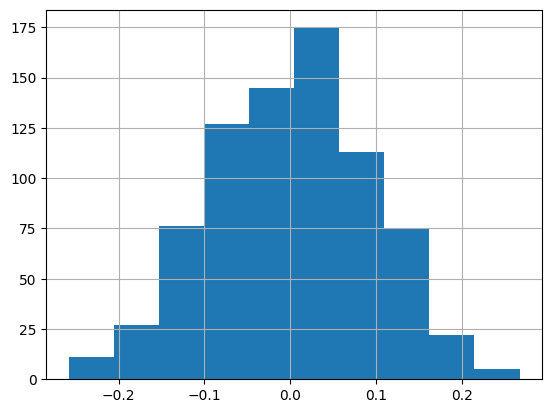

In [173]:
spearman_corr["spearman"].hist()
plt.show()

# Try https://www.kaggle.com/code/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert

### GloVe embeddings + LSTM

# Linear regression

In this part, we will solve an linear regression task to predict our target `score_compound`, i.e. continous sentiment score of tweets, using our features which are encodings of the tweets.


In [63]:
def make_yhat_in_range(yhat):
    """
    Takes predicted values of compound score and shapes them to be in range [-1,1]
    """
    transform = lambda y: np.maximum(-1, np.minimum(1, y))
    return transform(yhat)

In [64]:
#define some functions for plotting purposes

def plot_y_continous(y, bins=10, show=True, title=None):
    fig, ax = plt.subplots(1, 1)
    _ = ax.hist(y, bins=bins)
    if isinstance(title, str):
        ax.set_title(title)
    plt.tight_layout()
    if show: plt.show()

def plot_scatter(x, y,  show=True, x_label=None, y_label=None,  title=None):
    fig, ax = plt.subplots(1, 1)
    _ = ax.scatter(x,y)
    if isinstance(title, str):
        ax.set_title(title)
    if isinstance(x_label, str):
        ax.set_xlabel(x_label)
    if isinstance(y_label, str):
        ax.set_ylabel(y_label)
    plt.tight_layout()
    if show: plt.show()


In [129]:
#create X (feature matrix) and y (targets)
with open('train_data_embeddings_paraphrase-xlm-r-multilingual-v1.npy', 'rb') as f:
    sentence_embeddings = np.load(f)
X = sentence_embeddings
y = df.score_compound.values
print(f"X: {X.shape}")
print(f"y: {y.shape}")



X: (4096, 768)
y: (4096,)


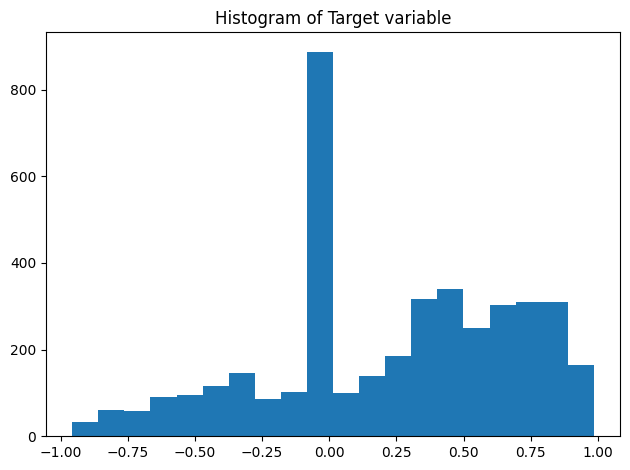

In [130]:
plt.close('all')
plot_y_continous(y, bins=20, title='Histogram of Target variable')

In its simplest form, predictions of a linear regression model can be summarized as

$$
\hat{y} = \mathbf{w}^T \mathbf{x} = f(\mathbf{x},\mathbf{w})
$$

which can be optimized the cost functions

$$
\mathbf{w}^{*}=\underset{\mathbf{w}}{\arg \min } \frac{1}{n} \sum_{i=1}^{n}\left(y_{i}-f\left(\mathbf{x}_{i}, \mathbf{w}\right)\right)^{2}
$$

In [67]:
from sklearn import linear_model
import sklearn.metrics as skm
import numpy as np

In [68]:
#split X and y for training and validation purposes
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

datasets = [
    [X_train, y_train],
    [X_val, y_val]
]

#create our linear regression model
reg = linear_model.LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)

Now fit a linear regression model on the training data.

In [69]:
reg = reg.fit(X_train, y_train)

In [70]:
# Evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'valididation'], datasets):
    X_i, y_i = dataset
    y_pred = reg.predict(X_i)

    rmse = np.sqrt(skm.mean_squared_error(y_i, y_pred))
    print(f'\nSplit: {split_name}')
    print(f"\tRMSE: {rmse:.10f}")
    mae = skm.mean_absolute_error(y_i, y_pred)
    print(f"\tMAE: {mae:.10f}")


Split: train
	RMSE: 0.2842111150
	MAE: 0.2201194538

Split: valididation
	RMSE: 0.3370807801
	MAE: 0.2608034099


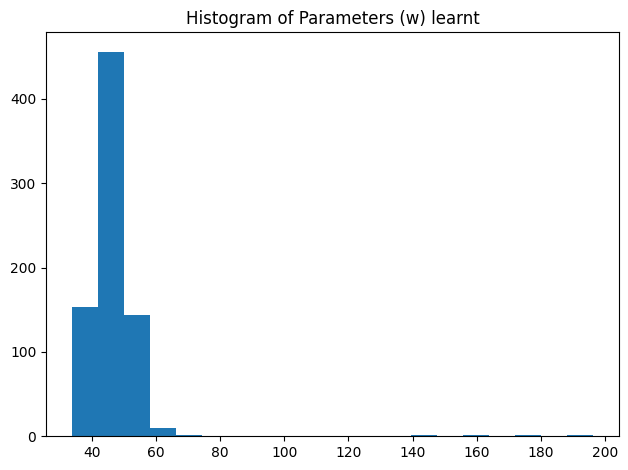

In [146]:
#plot the histogram of learnt weights w_i 
plot_y_continous(reg.coef_, bins=20, title='Histogram of Parameters (w) learnt')

### Elastic Net

*Observations:*

ElasticNet with alpha = 0.01 eliminates overfitting. Results are the following:

Split: train
	RMSE: 0.3517926398
	MAE: 0.2823657260

Split: valididation
	RMSE: 0.3548206993
	MAE: 0.2842167825

**With alpha = 0.01 ElasticNet sets to zero around 88% of features. If aplha is less, we face overfitting.**

In [162]:
from sklearn.linear_model import ElasticNet

#split X and y for training and validation purposes
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

datasets = [
    [X_train, y_train],
    [X_val, y_val]
]

#create our linear regression model
elastic_net = ElasticNet(alpha=0.01, fit_intercept=True, copy_X=True)
elastic_net.fit(X_train, y_train);

In [163]:
# Evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'valididation'], datasets):
    X_i, y_i = dataset
    y_pred = elastic_net.predict(X_i)

    rmse = np.sqrt(skm.mean_squared_error(y_i, y_pred))
    print(f'\nSplit: {split_name}')
    print(f"\tRMSE: {rmse:.10f}")
    mae = skm.mean_absolute_error(y_i, y_pred)
    print(f"\tMAE: {mae:.10f}")


Split: train
	RMSE: 0.3517926398
	MAE: 0.2823657260

Split: valididation
	RMSE: 0.3548206993
	MAE: 0.2842167825


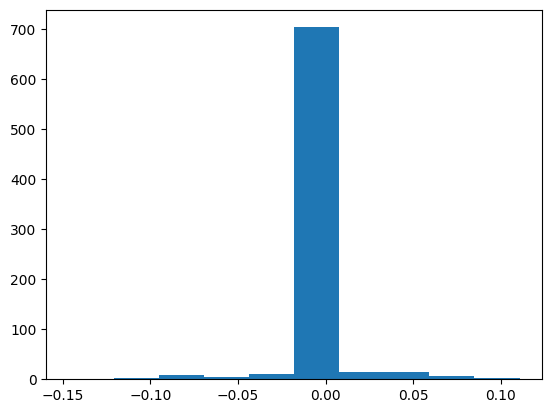

In [164]:
mpl.pyplot.hist(elastic_net.coef_.flatten())
plt.show()

In [165]:
# proportion of coefficients set to zero
(elastic_net.coef_.flatten() == 0).sum() / elastic_net.coef_.flatten().shape[0]

0.8802083333333334

At this point, we can use our model to predict sentiments scores of tweets from `X_test`, i.e. test set. Do not forget to encode them as well.

And save your predictions `y_hat` by naming it with the following format.

`<TEAM_ID>__<SPLIT>_reg_pred.npy`

Make sure that

`<TEAM_ID>` is your team id as given in CMS.

`<SPLIT>` is "test_1" during the semester and "test_2" for final submission. You will be notified when we need to move to "test_2".

In [ ]:
# Run this to save a file with your predictions on the test set to be submitted

sentences = list(df_test.words_str.values)
X_test = model.encode(sentences)
y_hat = reg.predict(X_test)

# Save the results with the format <TEAM_ID>__<SPLIT>_reg_pred.npy

folder = '/content/drive/MyDrive/ML_2023/students'
np.save(os.path.join(folder, f'{team_id}__{split}__reg_pred.npy'), y_hat)


# Linear classification

In this part, we will solve a linear classification task to predict our target `sentiment`, i.e. sentiment class of tweets, using our features which are encodings of the tweets.


In [ ]:
from sklearn import linear_model
from sklearn import preprocessing
import numpy as np

In [ ]:
def plot_y_discrete(y, show=True, title=None):
    fig, ax = plt.subplots(1, 1)
    sns.countplot(x=y, palette=colors, ax=ax)
    if isinstance(title, str):
        ax.set_title(title)
    plt.tight_layout()
    if show: plt.show()

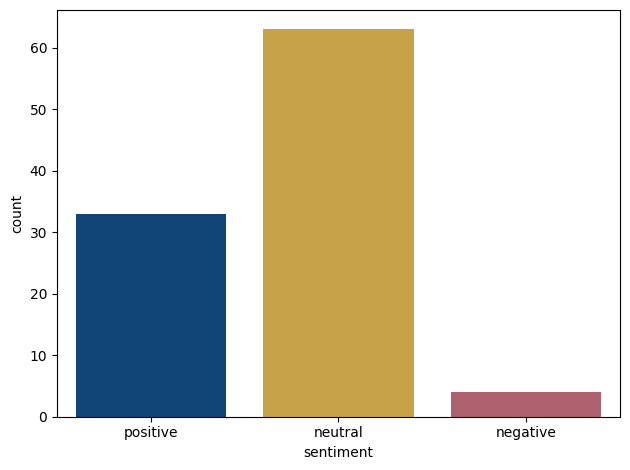

In [ ]:
plot_y_discrete(df.sentiment)

We will first change our targets (classes; positive, neutral, negative) to numeric targets. Then, we solve a logistic regression problem by minimizing the multinomial cross-entropy function

$$
J(\theta) = -\frac{1}{n} \sum_{i=1}^{n} \sum_{k=1}^{K} \mathbb{1}_{y_{i}=k} \log(p_{\theta}(\hat{y}=k | \mathbf{x}_{i}))
$$

where $y_i \in \{1,\ldots,K\}$ and $p_{\theta}(\hat{y}=k | \mathbf{x}_{i})$ is the probability assigned by our model to class $k$ having observed features $\mathbf{x}_{i}$.

In [ ]:
X = sentence_embeddings
y_text = df.sentiment.values
le = preprocessing.LabelEncoder()
le.fit(y_text)
print(f'Original classes {le.classes_}')
print(f'Corresponding numeric classes {le.transform(le.classes_)}')
y =le.transform(y_text)
print(f"X: {X.shape}")
print(f"y: {y.shape} {np.unique(y)}")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

datasets = [
    [X_train, y_train],
    [X_val, y_val]
]
clf = linear_model.LogisticRegression(penalty=None, 
                                      dual=False, 
                                      tol=0.0001, 
                                      C=1.0, 
                                      fit_intercept=True, 
                                      intercept_scaling=1, 
                                      class_weight=None, # None, balanced
                                      random_state=None, 
                                      solver='lbfgs', 
                                      max_iter=1000, 
                                      multi_class='auto', 
                                      verbose=0, 
                                      warm_start=False, 
                                      n_jobs=None, 
                                      l1_ratio=None
                                     )

Original classes ['negative' 'neutral' 'positive']
Corresponding numeric classes [0 1 2]
X: (100, 768)
y: (100,) [0 1 2]


Fit your model by using training data.

In [ ]:
clf = clf.fit(X_train, y_train)



Reminders about macro and micro averaging:


In the context of computing F1-score, "macro" and "micro" averaging are two commonly used techniques to aggregate the per-class F1-scores.

**Micro-average**: Compute the F1-score globally by counting the total true positives, false negatives, and false positives over all classes, and then calculating precision, recall, and F1-score using these aggregated values.

**Macro-average**: Calculate the F1-score for each class separately, and then take the average of these per-class F1-scores.

The main difference between these two techniques is the way they treat class imbalance. Micro-average treats all classes equally, regardless of their size, while macro-average treats each class equally, regardless of the number of samples in that class.

Micro-average is often used when we care about overall performance across all classes, and we want to give more weight to the performance on larger classes. In contrast, macro-average is often used when we want to evaluate the performance on each class separately and give equal weight to each class.


In addition to micro and macro averaging, there is another common technique for computing the F1-score called **weighted averaging**.

**Weighted averaging** is similar to macro averaging in that it computes the per-class F1-score and then takes the average of these scores. However, unlike macro averaging, weighted averaging takes into account the number of samples in each class when computing the average. Specifically, the weighted average is computed as follows:

- Compute the F1-score for each class separately.
- Compute the weight for each class as the number of samples in that class divided by the total number of samples.
- Compute the weighted average of the per-class F1-scores, where each per-class F1-score is weighted by the weight of that class.

The weighted average is commonly used when the dataset is imbalanced, meaning that some classes have many more samples than others. In such cases, using the simple average (macro-average) would give too much weight to the smaller classes, while using micro-average would give too much weight to the larger classes. The weighted average strikes a balance between these two approaches by giving more weight to the classes with more samples while still taking into account the performance of all classes.


Now evaluate your model

In [ ]:
for split_name, dataset in zip(['train', 'validation'], datasets):
    X_i, y_i = dataset
    y_pred = clf.predict(X_i)
    print(f'\nSplit: {split_name}')
    print(skm.classification_report(y_i, y_pred))


Split: train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        49
           2       1.00      1.00      1.00        27

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


Split: valididation
              precision    recall  f1-score   support

           1       0.75      0.86      0.80        14
           2       0.50      0.33      0.40         6

    accuracy                           0.70        20
   macro avg       0.62      0.60      0.60        20
weighted avg       0.68      0.70      0.68        20



At this point, we can use our model to predict sentiments scores of tweets from `X_test`, i.e. test set. Do not forget to encode them as well.

And save your predictions `y_hat` by naming it with the following format. 

`<TEAM_ID>__<SPLIT>_clf_pred.npy`

Make sure that

`<TEAM_ID>` is your team id as given in CMS.

`<SPLIT>` is "test_1" during the semester and "test_2" for final submission. You will be notified when we need to move to "test_2".

In [ ]:
# Run this to save a file with your predictions on the test set to be submitted
sentences = list(df_test.words_str.values)
X_test = model.encode(sentences)
y_hat = clf.predict(X_test)

# Save the results with the format <TEAM_ID>__<SPLIT>_clf_pred.npy

folder = '/content/drive/MyDrive/ML_2023/students'
np.save(os.path.join(folder, f'{team_id}__{split}__clf_pred.npy'), y_hat)

# Submission to CMS

Put your .npy files for both regression and classification tasks in the same zip file. Please name the file as `<TEAM_ID>.zip` and upload it to CMS system. It is essential that the files inside the .zip are named as follow:

`<TEAM_ID>__<SPLIT>__reg_pred.npy` \
`<TEAM_ID>__<SPLIT>__clf_pred.npy` \

Above, `<SPLIT>` should correspond to `test_1` for the leaderboard and `test_2` for the final submission. 